In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### loading data

In [64]:
data = pd.read_csv('car_train.txt',  sep='\s+', skiprows=1) #delim_whitespace=True,
data.columns = ["hp", "weight", "cylinders", "ccm", "km/l"]
data.head()

,hp,weight,cylinders,ccm,km/l
0,180.0,1986.7,8,5735.5,7.01
1,150.0,2021.7,8,5211.1,5.95
2,105.0,1767.6,6,4096.8,6.80
3,193.0,2146.4,8,4981.7,3.83
4,110.0,1378.5,6,3785.4,8.93


In [65]:
y_train = data['km/l']
y_train.head()

0    7.01
1    5.95
2    6.80
3    3.83
4    8.93
Name: km/l, dtype: float64

In [66]:
x_train = data.drop(["km/l"],axis=1)
x_train.head()

,hp,weight,cylinders,ccm
0,180.0,1986.7,8,5735.5
1,150.0,2021.7,8,5211.1
2,105.0,1767.6,6,4096.8
3,193.0,2146.4,8,4981.7
4,110.0,1378.5,6,3785.4


In [67]:
data_test = pd.read_csv('car_test.txt', sep='\s+', skiprows=1)
data_test.columns = ["hp", "weight", "cylinders", "ccm", "km/l"]
y_test = data_test['km/l']
x_test = data_test.drop(["km/l"],axis=1)

### normalization

In [68]:
def normalize(data, target, test_data, test_target):
    """
    makes the data follow a standard normal

    params
    ------
    dataframes of train and test data 
    x traain, y train, x test, y test

    returns 
    -------
    np.ndarray, np.ndarray : normalized train data, normalized test data
    """
    data = data.to_numpy()
    test_data = test_data.to_numpy()
    target = target.to_numpy()
    test_target = test_target.to_numpy()


    mean = [] # means of each feature of the train set
    std = [] # standard deviations of each feature of the train set

    # for each column ( feature )
    for i in range(data.shape[1]):
        mean.append(np.mean(data[:,i])) # mean 
        std.append(np.std(data[:,i])) # std

    target_mean = np.mean(target) # mean
    target_std = np.std(target) # std


    # normalize the matrices
    data = (data - mean)/std
    test_data = (test_data - mean)/std

    target = (target - target_mean)/target_std
    test_target = (test_target - target_mean)/target_std

    return data, target, test_data, test_target


In [69]:
x_train, y_train, x_test, y_test = normalize(x_train, y_train, x_test, y_test)

# 1. linear regression - gradient descent

Loss function:
$$
L(\theta) = \frac{1}{2n} \sum_{i=1}^{n} (h_{\theta}(x^{(i)}) - y^{(i)})^2
$$

Derivative of the loss function:
$$
\frac{d L(\theta)}{d \theta} = \frac{1}{n} \sum_{i=1}^{n} (h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}
$$

$x^{(i)}$ is the instance i from the data, 
$h_{\theta}(x^{(i)})$ is the predicted value of the instance $x^{(i)}$, 
$y^{(i)}$ is the actual value of the instance $x^{(i)}$

Our training set has $k$ features and $n$ instances

$$
=\frac{1}{n} \sum_{i=1}^{n} (y_{pred}^{(i)} - y^{(i)}) \begin{bmatrix} 1\\ x_1^{(i)} \\ \vdots \\ x_k^{(i)} \end{bmatrix}
=\frac{1}{n} \begin{pmatrix} 1 & 1 & ... & 1 \\ x_1^{(1)} & x_1^{(2)} & ... & x_1^{(n)} \\ \vdots \\  x_k^{(1)} & x_k^{(2)} & ... & x_k^{(n)}   \end{pmatrix} 
\begin{bmatrix} y_{pred}^{(0)} - y^{(0)} \\ y_{pred}^{(1)} - y^{(1)} \\ ... \\ y_{pred}^{(n)} - y^{(n)}\end{bmatrix} 
$$

$$= \frac{1}{n}X_{\text{train}}^T  (\mathbf{y}_{\text{pred}} - \mathbf{y}_{\text{train}}) 
$$


where $X_{\text{train}}$ is the training data matrix
and $\mathbf{y}_{\text{pred}}$ is the prediction vector



In [70]:
def loss(theta, x_train, y_train):
    """linear regression loss function"""
    n = len(y_train)
    y_pred = np.dot(x_train, theta) # matrix * theta
    loss = np.sum((y_pred - y_train) ** 2) / (2 * n)
    return loss

def grad(theta, x_train, y_train):
    """gradient(theta, x_train, y_train)"""
    n = len(y_train)
    y_pred = np.dot(x_train, theta) # matrix * theta
    grad = np.dot(x_train.T, (y_pred - y_train)) / n  
    return grad

In [71]:
def plot_losses(losses):
    """
    plotting the loss function in gradient descent
    """
    iters = pd.Series(range(len(losses)))
    losses = pd.DataFrame(losses)
    losses.set_index([iters])
    losses.columns = ["loss"]
    sns.set_theme()
    fig = sns.lineplot(data=losses, x=losses.index, y="loss")
    fig.set(xlabel="Iterations", ylabel="Loss")
    plt.show()
    

In [72]:
def gradient_descent(x_train, y_train, epsilon=1e-3, delta=1e-3):
    """
    standardize before using, call standardize()

    parameters
    ----------
    x_train : training data
    y_train : labels
    
    returns
    -------
    parameter vector
    """
    # learning rate
    L = 0.02
    
    # initialize theta to zeros
    theta = np.ones(5)
    theta_old = np.zeros(5)

    # adding a column of 1 to the left of x_train
    col_ones = np.ones(x_train.shape[0])
    x_train = np.column_stack((col_ones, x_train))
    # n = 5
    n = x_train.shape[1]

    losses = []
    iters = 0
    while abs(loss(theta, x_train, y_train)) > delta and abs(np.linalg.norm(theta-theta_old,2)) > epsilon and iters < 1000:
        theta_old = theta.copy()
        theta = theta - L * grad(theta, x_train, y_train)
        losses.append(loss(theta, x_train, y_train))
        #print(f'\n\n old theta = {theta_old},\n theta = {theta}')
        iters += 1

    print("Gradient descent results:")
    print(f'  loss = {loss(theta, x_train, y_train)},\n  |thetaold - thetanew| = {abs(np.linalg.norm(theta-theta_old,2))}\n  iters = {iters}\n  learning rate = {L}')

    print(f"Theta = {theta}")
    plot_losses(losses)
    return theta    


Gradient descent results:
  loss = 0.14595412415200934,
  |thetaold - thetanew| = 0.0009890956483028326
  iters = 160
  learning rate = 0.02
Theta = [ 0.03946137 -0.19817762 -0.29969781 -0.15834542 -0.21645123]


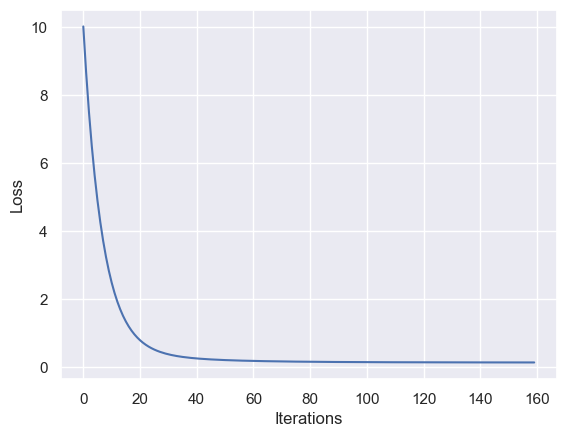

In [73]:
theta = gradient_descent(x_train, y_train)

## my linear regression error

In [74]:
def predict(test_data, coefficients):
    """
    fits linear regression model with given coefficients to given test data

    params
    ------
    test_data : test data
    coefficients : coefficients of linear regression model ( theta)

    returns
    -------
    predictions vector y_pred

    """
    intercept = coefficients[0]
    coefficients = coefficients[1:]
    return np.dot(test_data, coefficients) + intercept

def error(y_true, y_pred):
    """2-norm difference of 2 vectors"""
    return np.linalg.norm((y_true - y_pred),2)

In [75]:
y_pred = predict(x_test, theta)
print(error(y_test, y_pred))

5.362352376841269


## sklearn error

In [76]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
print(error(y_test, y_pred))

5.140307249931667
